In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

if 'KERAS_BACKEND' not in os.environ:
    os.environ['KERAS_BACKEND'] = 'tensorflow'

In [3]:
import numpy as np
import bayesflow as bf

2025-06-08 01:29:29.653828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749360569.789530  222487 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749360569.834536  222487 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749360570.117739  222487 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749360570.117770  222487 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749360570.117772  222487 computation_placer.cc:177] computation placer alr

# Principle Bayesian Workflow for Cognitive Modeling with SSMS and BayesFlow

 In this tutorial, we go through the steps of a [principled Bayesian workflow](https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html) for developing and applying cognitive models. To demonstrate this workflow, we simulate some cognitive processes using the [Sequential Sampling Model Simulators (SSMS)](https://lnccbrown.github.io/ssm-simulators/api/ssms/), the simulator backbone for the [Hierarchical Sequential Sampling Model (HSSM) toolbox](https://lnccbrown.github.io/HSSM/). From the simulated data, we perform Amortized Bayesian inference using [BayesFlow](https://bayesflow.org).

## Simulator

We start with the basic simulator from the HSSM toolbox.

In [4]:
from ssms.basic_simulators.simulator import simulator as ssm_sim

In [23]:
def ddm_simulator(
        v=None, a=None, z=None, t=None,
        n_samples: int=100
):
    
    ddm_sim = ssm_sim(model="ddm", theta=dict(v=v, a=a, z=z, t=t), n_samples=n_samples)

    rts = ddm_sim['rts'].astype(np.float32)
    choices = ddm_sim['choices'].astype(np.float32)

    return dict(rts=rts, choices=choices)

## Priors

Next, we will sample some priors from some distribution, as follows:

\begin{equation}
v \sim \mathrm{Gamma}(2, 0.8), \; a \sim \mathrm{Gamma}(10, 0.2), \; z \sim \mathrm{Beta}(2, 2), \; t \sim \mathrm{Gamma}(1.5, 0.2).
\end{equation}

In [43]:
def priors(rng=None):

    if rng is None:
        rng = np.random.default_rng()

    drift = rng.gamma(2, 0.8)
    threshold = rng.gamma(10, 0.2)
    bias = rng.beta(2, 2)
    ndt = rng.gamma(1.5, 0.2)

    return {'v': drift, 'a': threshold, 'z': bias, 't': ndt}

In [44]:
theta = priors()
theta

{'v': 0.26629856832974397,
 'a': 1.2552243174633644,
 'z': 0.8254465921142345,
 't': 0.3598617326233199}

## Putting everything together

After specifying the simulator and priors, we would wrap them together using BayesFlow's `make_simulator` function.

In [45]:
simulator = bf.make_simulator([priors, ddm_simulator])

In [46]:
draws = simulator.sample(batch_size=2)

In [47]:
print(draws['v'].shape)
print(draws['t'].shape)
print(draws['rts'].shape)
print(draws['choices'].shape)

(2, 1)
(2, 1)
(2, 100, 1)
(2, 100, 1)


## Prior Predictive Checks

To make sure that we are sampling the priors properly, BayesFlow has a pretty nice visual inspection in its `diagnostics` module that allows us to observe the samples directly.

In [48]:
prior_samples = simulator.simulators[0].sample(500)

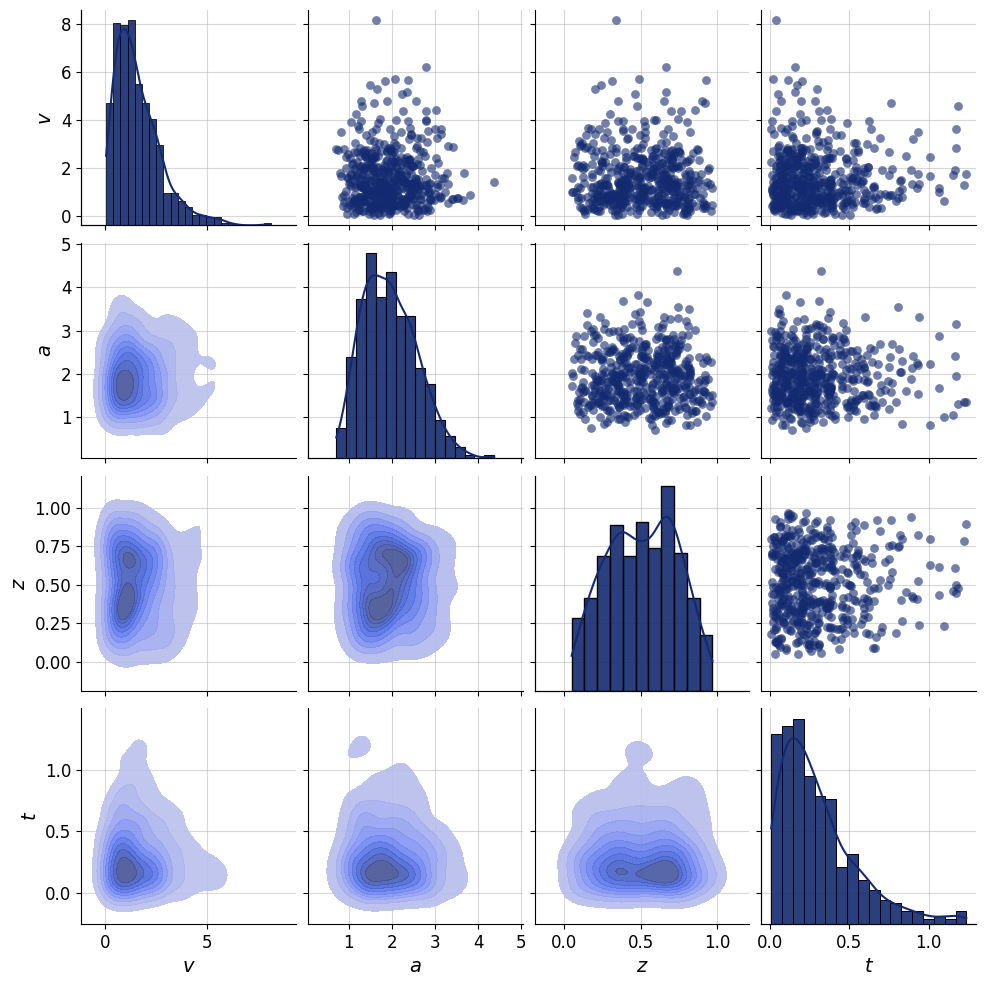

In [49]:
prior_grid = bf.diagnostics.plots.pairs_samples(
    samples=prior_samples, variable_names=[r'$v$', r'$a$', r'$z$', r'$t$']
)

## Adapter

To make sure that the simulated data and priors all friendly to the neural approximator, we use BayesFlow's `Adapter` to transform the data into summary variables and inference variables.

In a nutshell, from the perspective of the neural approximator:

* **Summary variables** are simulated data, and
* **Inference variables** are the parameters.

In [50]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype('float64', 'float32')
    .standardize()
    .concatenate(['v', 'a', 'z', 't'], into="inference_variables")
    .concatenate(['rts', 'choices'], into="summary_variables")
)

In [51]:
adapter

Adapter([0: ConvertDType -> 1: Standardize -> 2: Concatenate(['v', 'a', 'z', 't'] -> 'inference_variables') -> 3: Concatenate(['rts', 'choices'] -> 'summary_variables')])

We can inspect the transformed data after wrapping the simulation in the adapter to process.

In [52]:
adapted_sims = adapter(simulator.sample(10))

In [53]:
print(adapted_sims['summary_variables'].shape)
print(adapted_sims['inference_variables'].shape)

(10, 100, 2)
(10, 4)


## Neural approximator

The neural approximator is essentially a two-stage generative neural network consisting of a **summary network** and an **inference network**.

* **Summary network** takes the simulated data (*summary variables*) directly as inputs, and compress it into some latent summary statistics,
* **Inference network** takes the summary statistics as inputs, and infers the parameters (*inference variables*) from them.

In [54]:
summary_net = bf.networks.SetTransformer(summary_dim=32)

In [55]:
inference_net = bf.networks.FlowMatching()

## Workflow

BayesFlow makes everything easier by wrapping the amortization into a `Workflow` object. Here, we can simply use a `BasicWorkflow` object that bring together the simulator, the adapter, the summary network, and the inference network.

In [56]:
workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    summary_network=summary_net,
    inference_network=inference_net
)

In [57]:
%%time 
_ = workflow.simulate(32)

CPU times: user 340 ms, sys: 3.17 ms, total: 343 ms
Wall time: 340 ms


## Training

Using the `BasicWorkflow` object, we can generate training data and validation data for training the neural approximator.

In [58]:
training_data = workflow.simulate(5000)
validation_data = workflow.simulate(300)

In [59]:
history = workflow.fit_offline(
    data=training_data,
    epochs=50,
    batch_size=32,
    validation_data=validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 115ms/step - loss: 3.7692 - loss/inference_loss: 3.7692 - val_loss: 0.7768 - val_loss/inference_loss: 0.7768
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 110ms/step - loss: 1.4770 - loss/inference_loss: 1.4770 - val_loss: 0.9637 - val_loss/inference_loss: 0.9637
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - loss: 1.2062 - loss/inference_loss: 1.2062 - val_loss: 1.2623 - val_loss/inference_loss: 1.2623
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - loss: 1.0904 - loss/inference_loss: 1.0904 - val_loss: 0.8736 - val_loss/inference_loss: 0.8736
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - loss: 1.0133 - loss/inference_loss: 1.0133 - val_loss: 1.0349 - val_loss/inference_loss: 1.0349
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - loss: 0.9785 - loss/inference_loss: 0.9785 - val_loss: 0.8574 - val_loss/inference_loss: 0.8574
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - loss: 0.9407 - loss/infer

## Diagnostics

The `Workflow` object also gather all the diagnostics functionality that BayesFlow has to offer.

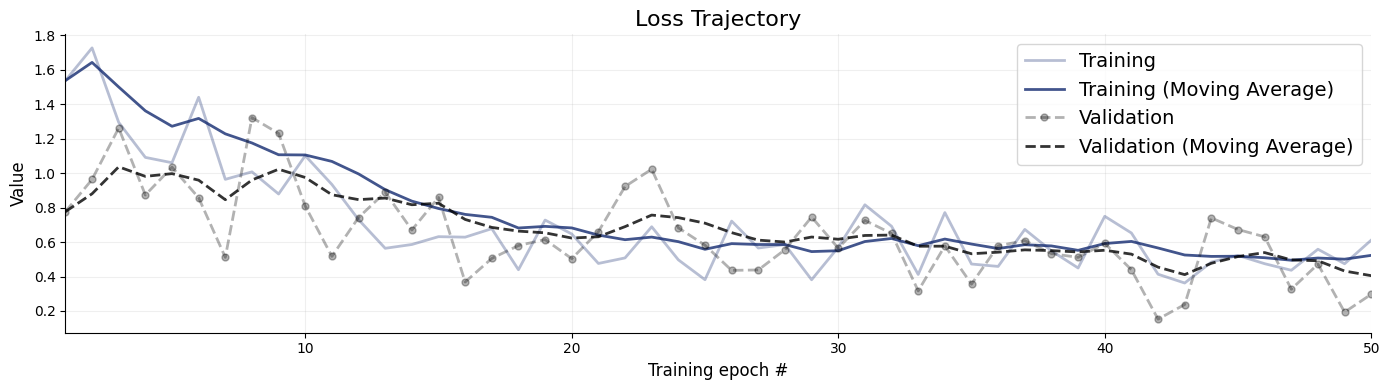

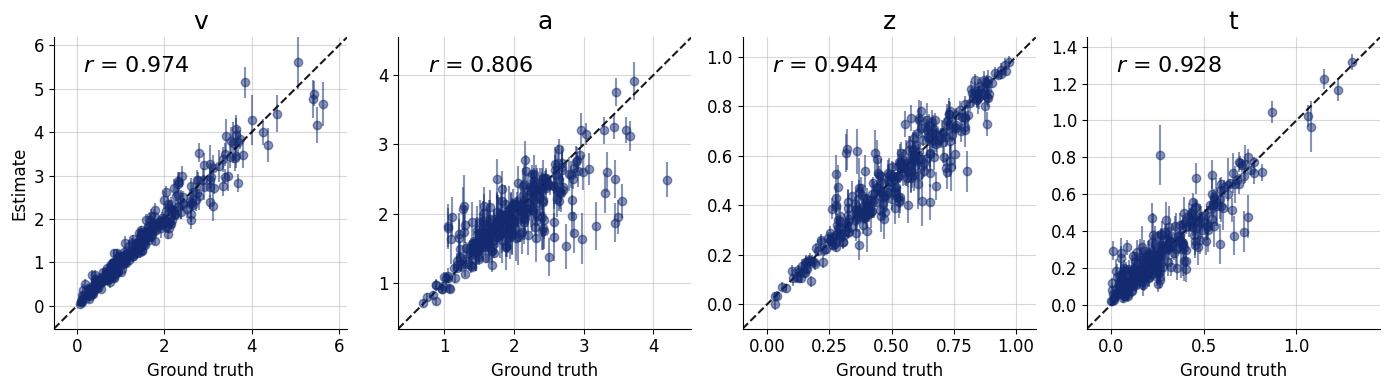

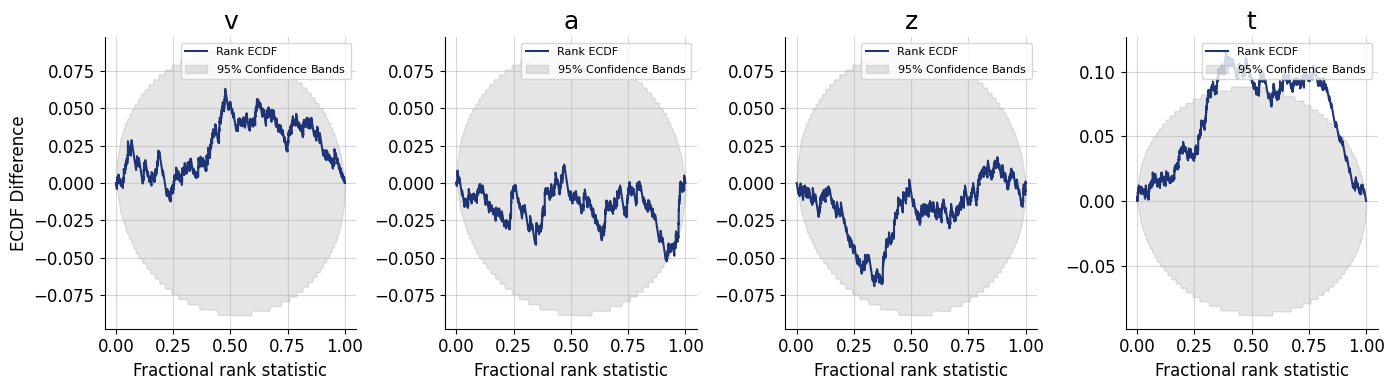

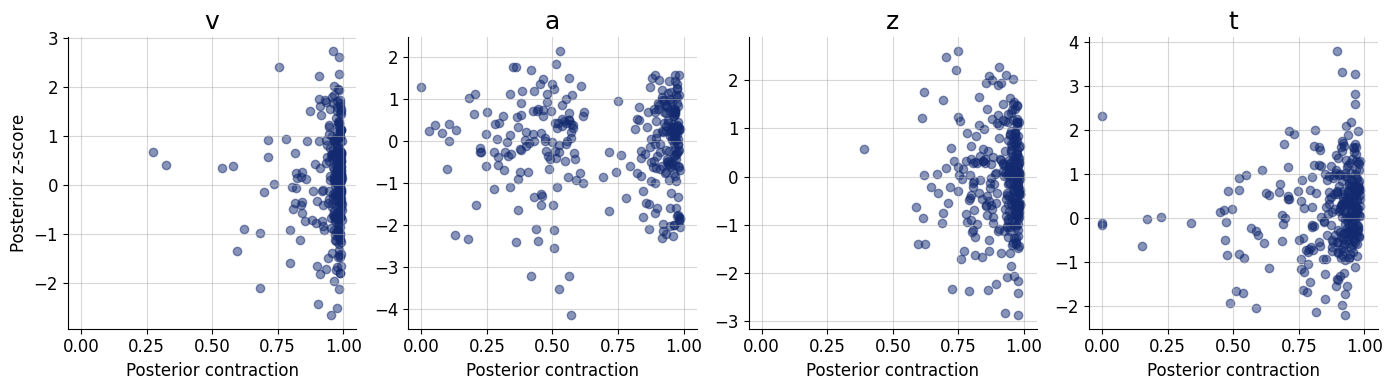

In [60]:
figures = workflow.plot_default_diagnostics(
    test_data=300,
    loss_kwargs={"figsize": (14, 4), "label_fontsize": 12},
    recovery_kwargs={"figsize": (14, 4), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (14, 4), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (14, 4), "label_fontsize": 12}    
)

gMore materials coming soon...